In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-cities-aqi-2020-2024/jaipur_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/mumbai_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/bengaluru_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/gwalior_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/lucknow_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/visakhapatnam_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/kolkata_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/chennai_combined.csv
/kaggle/input/indian-cities-aqi-2020-2024/hyderabad_combined.csv


In [18]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost joblib



In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
import joblib


In [20]:
DATA_PATH = "/kaggle/input/indian-cities-aqi-2020-2024/delhi_combined.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,Timestamp,Location,PM2.5,PM10,NO2,NH3,SO2,CO,O3
0,01-01-2020,Delhi - Punjabi Bagh,420.68,507.60,105.21,63.96,6.30,2.26,9.49
1,02-01-2020,Delhi - Punjabi Bagh,364.73,480.09,79.38,51.28,9.69,2.87,8.03
2,03-01-2020,Delhi - Punjabi Bagh,227.72,309.23,57.22,44.29,11.04,2.69,8.18
3,04-01-2020,Delhi - Punjabi Bagh,243.86,323.75,60.99,44.88,12.61,1.94,11.72
4,05-01-2020,Delhi - Punjabi Bagh,161.66,222.79,56.22,38.35,11.03,1.91,12.37


In [21]:
#  Timestamp conversion 
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d-%m-%Y")

# Extracting the  time features
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday

# Removing the original timestamp
df.drop(columns=['Timestamp'], inplace=True)


In [22]:
# Replacing the  negative or invalid values
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
df[pollutants] = df[pollutants].apply(pd.to_numeric, errors='coerce')

# Filling out the  missing values using median 
for col in pollutants:
    df[col].fillna(df[col].median(), inplace=True)


/tmp/ipykernel_111/3435226390.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [23]:
def calculate_aqi(row):
    return max(row['PM2.5'], row['PM10'], row['NO2'], 
               row['NH3'], row['SO2'], row['O3'])

df['AQI'] = df.apply(calculate_aqi, axis=1)


In [24]:
def aqi_category(aqi):
    if aqi <= 50:
        return 0
    elif aqi <= 100:
        return 1
    elif aqi <= 200:
        return 2
    elif aqi <= 300:
        return 3
    elif aqi <= 400:
        return 4
    else:
        return 5

df['AQI_Category'] = df['AQI'].apply(aqi_category)


In [25]:
def aqi_category(aqi):
    if aqi <= 50:
        return 0
    elif aqi <= 100:
        return 1
    elif aqi <= 200:
        return 2
    elif aqi <= 300:
        return 3
    elif aqi <= 400:
        return 4
    else:
        return 5

df['AQI_Category'] = df['AQI'].apply(aqi_category)


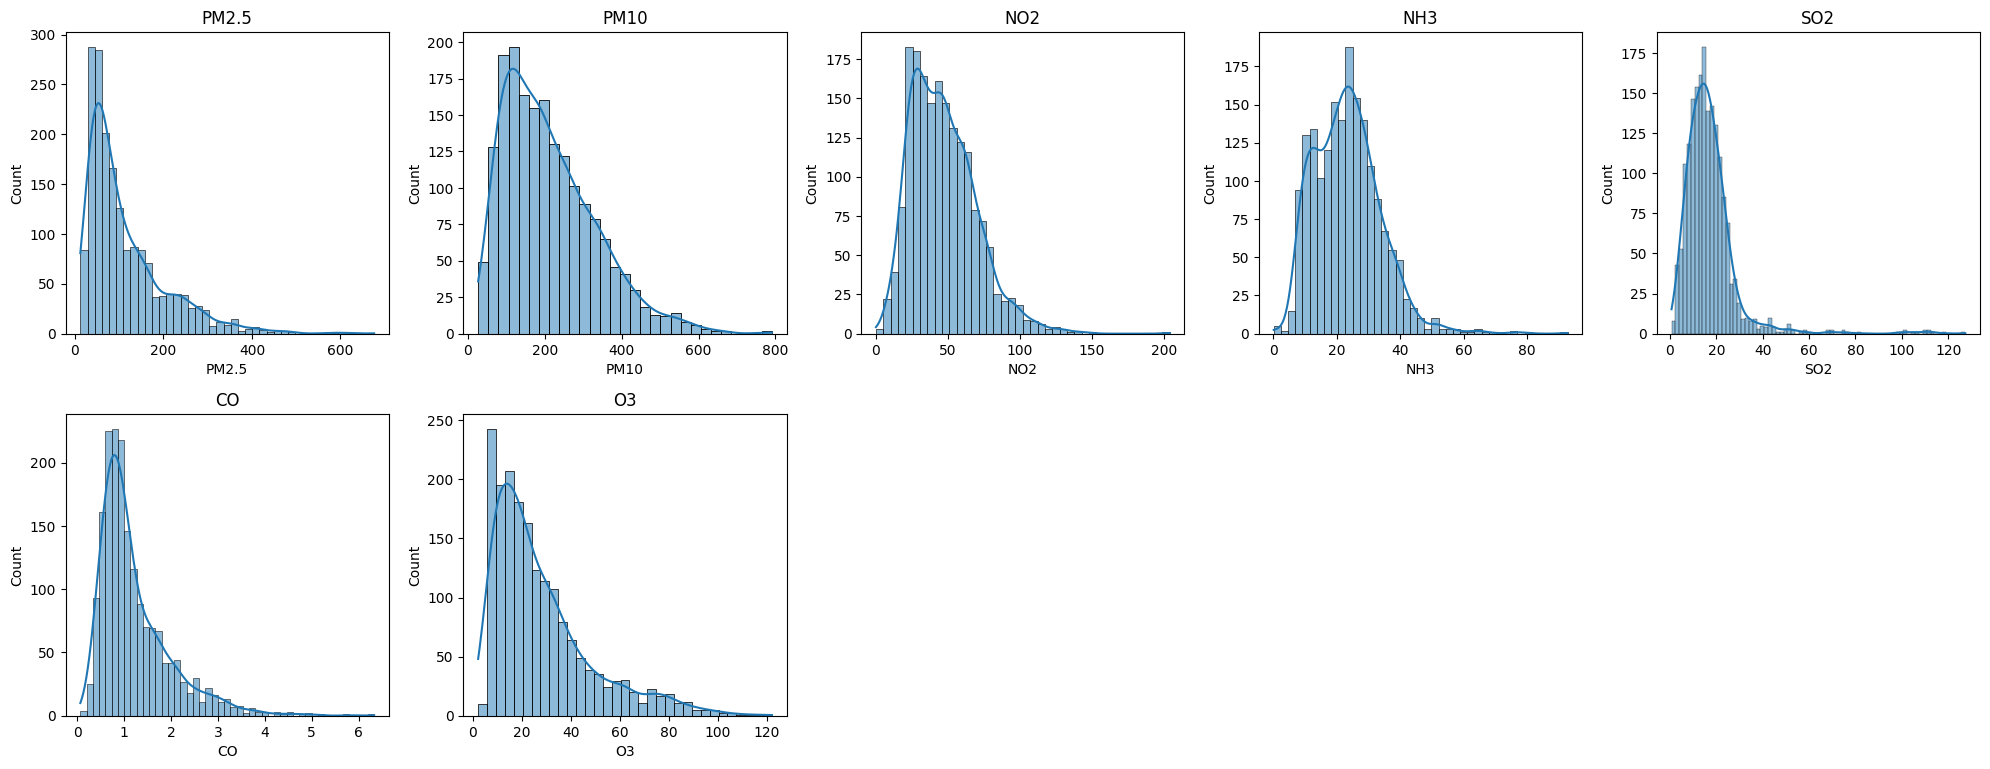

In [26]:
plt.figure(figsize=(20,15))

for i, col in enumerate(pollutants, 1):
    plt.subplot(4,5,i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


In [39]:
# Reconstruct the Timestamp from the extracted columns
df['Timestamp'] = pd.to_datetime(df[['year', 'month', 'day']])

# Now you can set it as index again for resampling
df_features = df.set_index('Timestamp')

# Verification
print(df_features.index.dtype) # Should be datetime64[ns]

datetime64[ns]


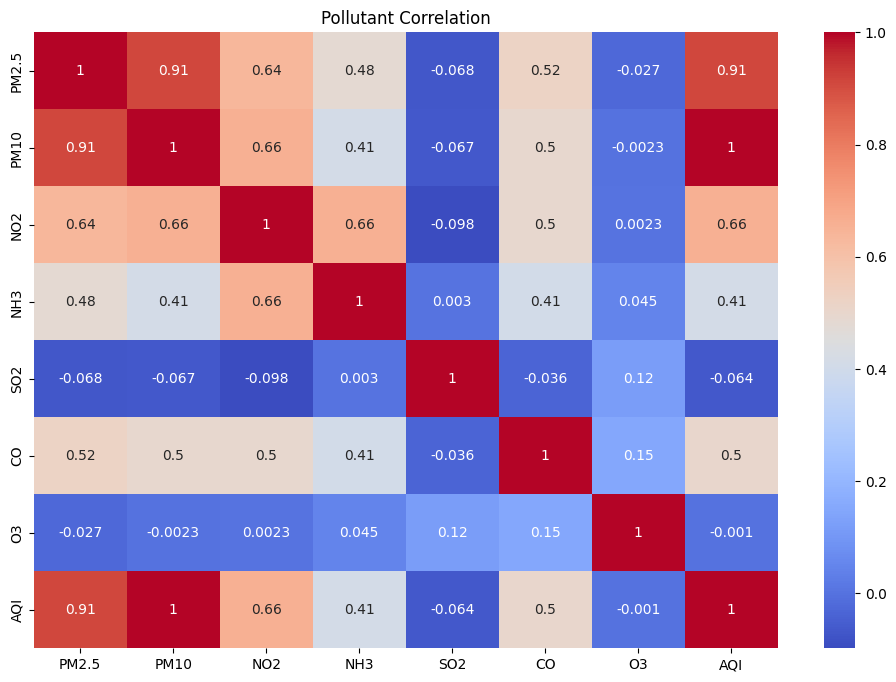

In [40]:
#   Plotting the pollution Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[pollutants].corr(), annot=True, cmap='coolwarm')
plt.title("Pollutant Correlation")
plt.show()


In [41]:
df_features = df.copy()

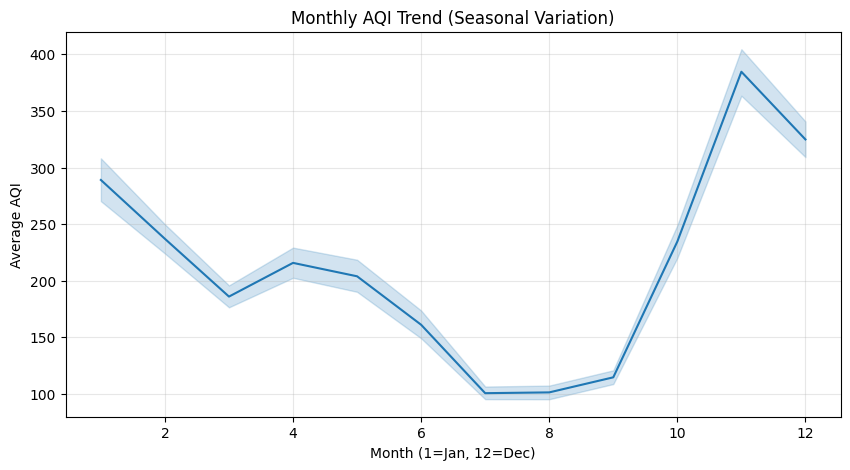

In [42]:
# Monthly AQI Trend using the engineered features
plt.figure(figsize=(10,5))
sns.lineplot(x='month', y='AQI', data=df_features)
plt.title("Monthly AQI Trend (Seasonal Variation)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Average AQI")
plt.grid(True, alpha=0.3)
plt.show()

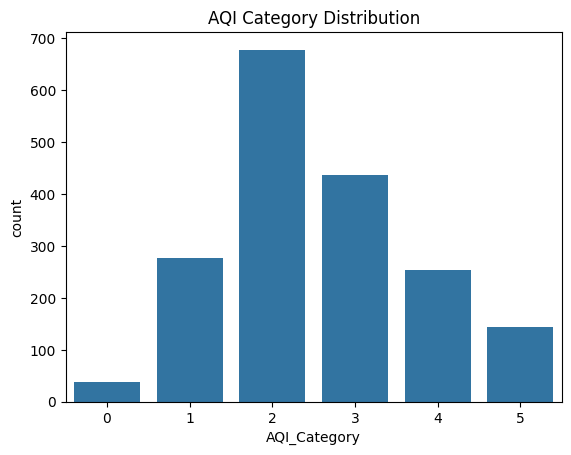

In [30]:
# AQI Category Count
sns.countplot(x='AQI_Category', data=df)
plt.title("AQI Category Distribution")
plt.show()


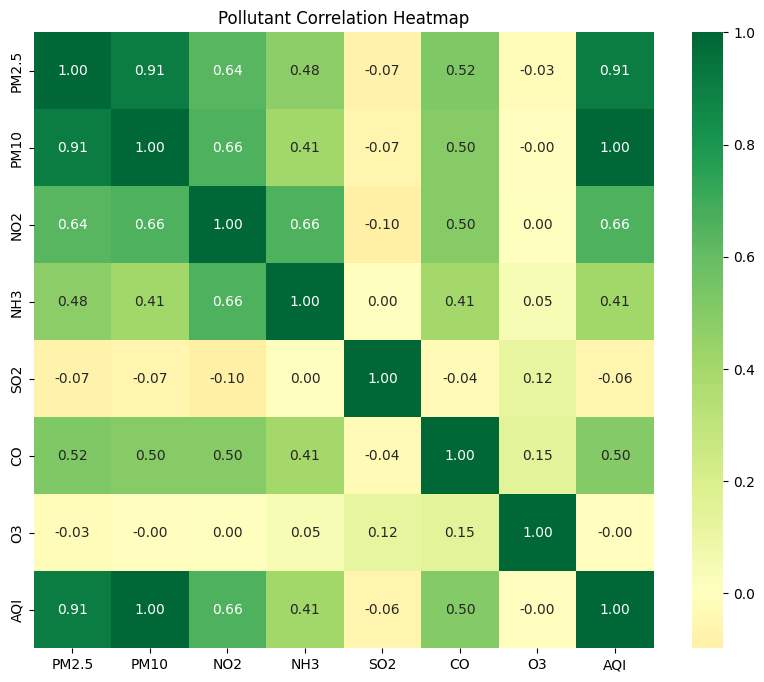

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating the pollution   correlation matrix
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 'AQI']
corr_matrix = df_features[pollutants].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title("Pollutant Correlation Heatmap")
plt.show()

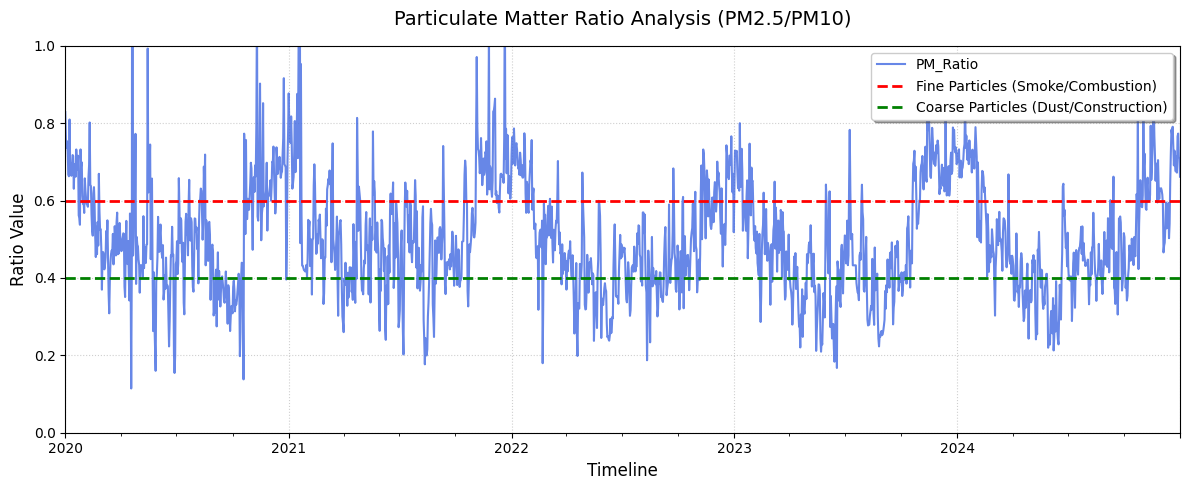

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a working copy to avoid SettingWithCopy warnings
df_plot = df_features.copy()

# 2. Ensure 'Timestamp' is a column (reset if it's the index)
if 'Timestamp' not in df_plot.columns:
    if df_plot.index.name == 'Timestamp' or str(df_plot.index.dtype).startswith('datetime'):
        df_plot = df_plot.reset_index()
    else:
        # If Timestamp is completely missing, we check other column names
        print("Columns found:", df_plot.columns.tolist())
        raise KeyError("The 'Timestamp' column is missing from the DataFrame.")

# 3. Convert to datetime and set as index
df_plot['Timestamp'] = pd.to_datetime(df_plot['Timestamp'], errors='coerce')
df_plot = df_plot.dropna(subset=['Timestamp']) # Remove any rows with invalid dates
df_plot = df_plot.set_index('Timestamp')

# 4. Calculate the ratio safely
# We add a small epsilon (1e-10) to prevent division by zero
df_plot['PM_Ratio'] = df_plot['PM2.5'] / (df_plot['PM10'] + 1e-10)

# 5. Plotting
plt.figure(figsize=(12, 5))

# Resampling to 'D' (Daily) to smooth out noise
df_plot['PM_Ratio'].resample('D').mean().plot(color='royalblue', lw=1.5, alpha=0.8)

# Add Scientific Threshold Lines
plt.axhline(y=0.6, color='red', linestyle='--', linewidth=2, label='Fine Particles (Smoke/Combustion)')
plt.axhline(y=0.4, color='green', linestyle='--', linewidth=2, label='Coarse Particles (Dust/Construction)')

# Formatting for Research Paper
plt.title("Particulate Matter Ratio Analysis (PM2.5/PM10)", fontsize=14, pad=15)
plt.xlabel("Timeline", fontsize=12)
plt.ylabel("Ratio Value", fontsize=12)
plt.ylim(0, 1) # Ratios usually stay between 0 and 1
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

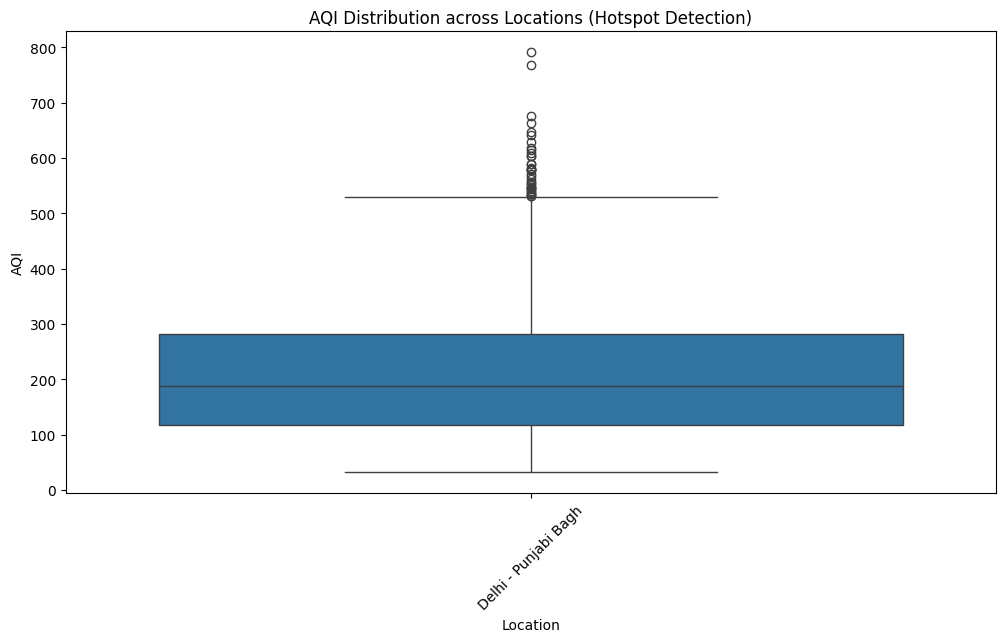

In [35]:
plt.figure(figsize=(12, 6))
# Sorting the  locations by average AQI
location_order = df_features.groupby('Location')['AQI'].mean().sort_values(ascending=False).index

sns.boxplot(x='Location', y='AQI', data=df_features, order=location_order)
plt.xticks(rotation=45)
plt.title("AQI Distribution across Locations (Hotspot Detection)")
plt.show()

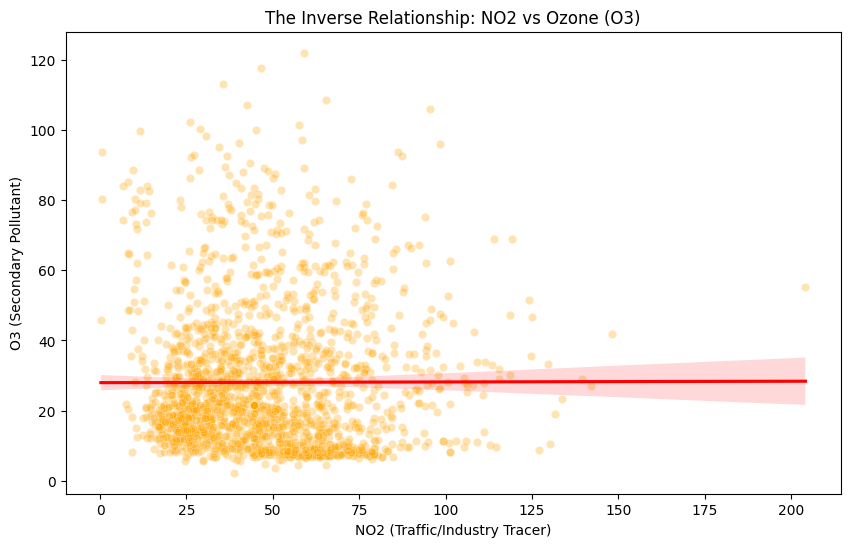

In [44]:
plt.figure(figsize=(10, 6))
# Scatter plot for  inverse relationship
sns.scatterplot(x='NO2', y='O3', data=df_features, alpha=0.3, color='orange')

# Trend line
sns.regplot(x='NO2', y='O3', data=df_features, scatter=False, color='red')

plt.title("The Inverse Relationship: NO2 vs Ozone (O3)")
plt.xlabel("NO2 (Traffic/Industry Tracer)")
plt.ylabel("O3 (Secondary Pollutant)")
plt.show()

/tmp/ipykernel_111/916483230.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_name', y='AQI', data=df_plot, order=day_names, palette='viridis')


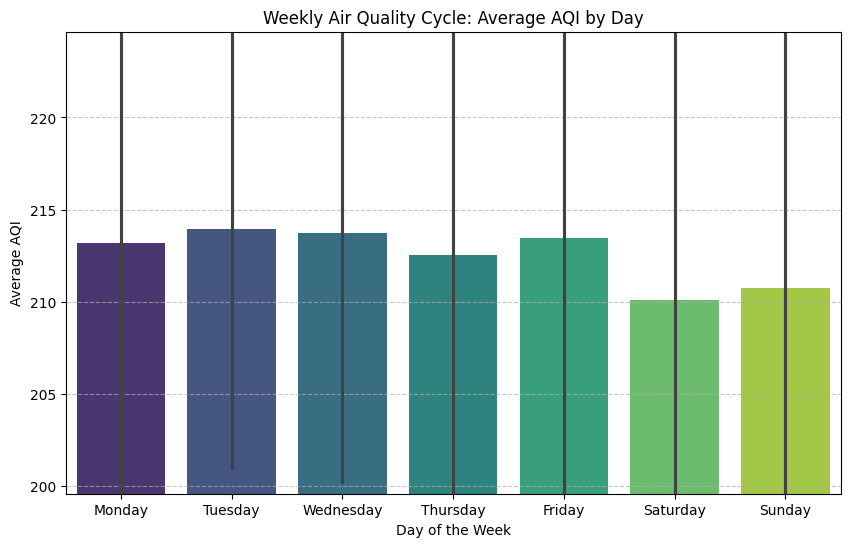

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Handle the Timestamp (Check if it's the Index or a Column)
df_plot = df_features.copy()

if 'Timestamp' not in df_plot.columns:
    if df_plot.index.name == 'Timestamp' or str(df_plot.index.dtype).startswith('datetime'):
        # If it's the index, extract the day name directly from the index
        df_plot['day_name'] = df_plot.index.day_name()
    else:
        print("Available columns:", df_plot.columns.tolist())
        raise KeyError("Could not find 'Timestamp' in columns or index.")
else:
    # If it's a column, ensure it's datetime and then extract
    df_plot['Timestamp'] = pd.to_datetime(df_plot['Timestamp'])
    df_plot['day_name'] = df_plot['Timestamp'].dt.day_name()

# 2. Plotting
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.barplot(x='day_name', y='AQI', data=df_plot, order=day_names, palette='viridis')

plt.title("Weekly Air Quality Cycle: Average AQI by Day")
plt.xlabel("Day of the Week")
plt.ylabel("Average AQI")

# Dynamic Y-axis limits to highlight the difference
y_min = df_plot.groupby('day_name')['AQI'].mean().min() * 0.95
y_max = df_plot.groupby('day_name')['AQI'].mean().max() * 1.05
plt.ylim(y_min, y_max)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

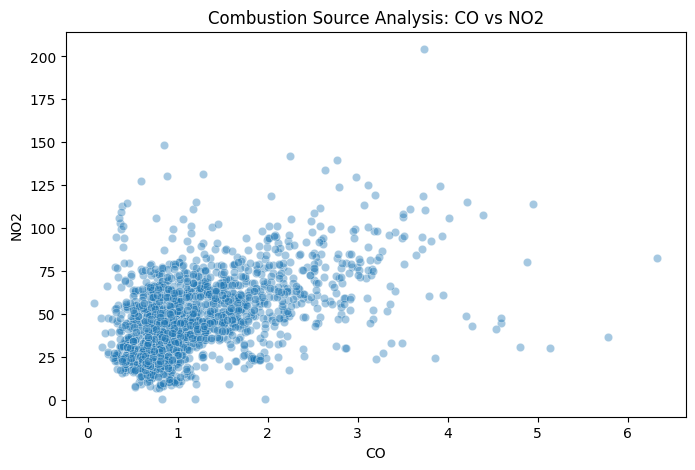

In [46]:
#plotting Combustion Source Analysis CO /NO2
plt.figure(figsize=(8, 5))
sns.scatterplot(x='CO', y='NO2', data=df_features, alpha=0.4)
plt.title("Combustion Source Analysis: CO vs NO2")
plt.show()

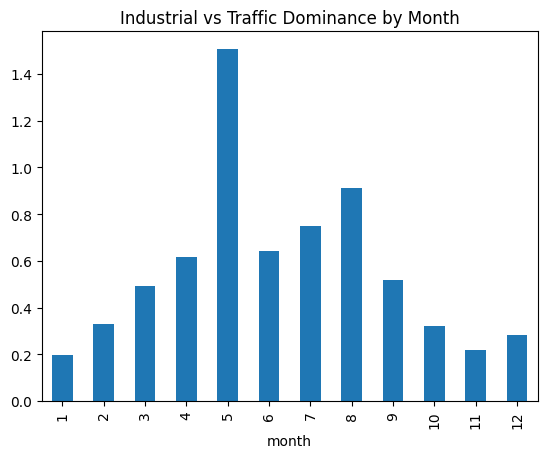

In [47]:
#comparing industrial vs Traffic for AQI production 
df_features['SO2_NO2_Ratio'] = df_features['SO2'] / (df_features['NO2'] + 1e-5)
df_features.groupby('month')['SO2_NO2_Ratio'].mean().plot(kind='bar')
plt.title("Industrial vs Traffic Dominance by Month")
plt.show()

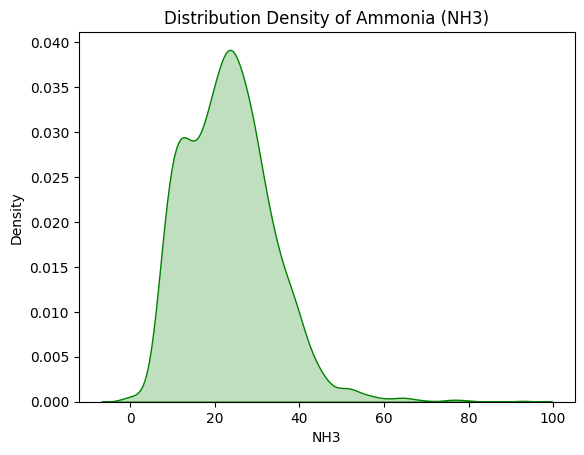

In [48]:
# plotting the NH3 Distribution 
sns.kdeplot(df_features['NH3'], fill=True, color='green')
plt.title("Distribution Density of Ammonia (NH3)")
plt.show()

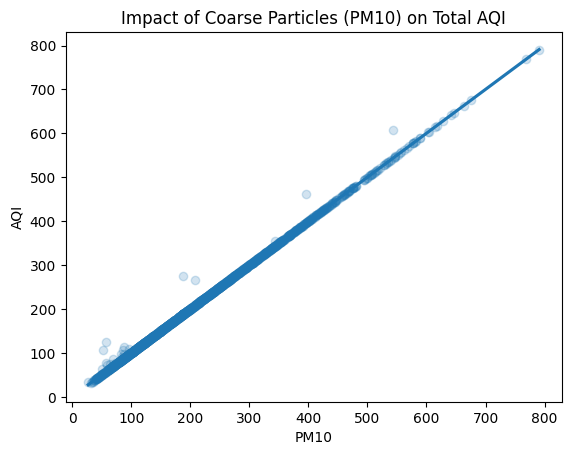

In [49]:
#Plotting Impact of PM10
sns.regplot(x='PM10', y='AQI', data=df_features, scatter_kws={'alpha':0.2})
plt.title("Impact of Coarse Particles (PM10) on Total AQI")
plt.show()

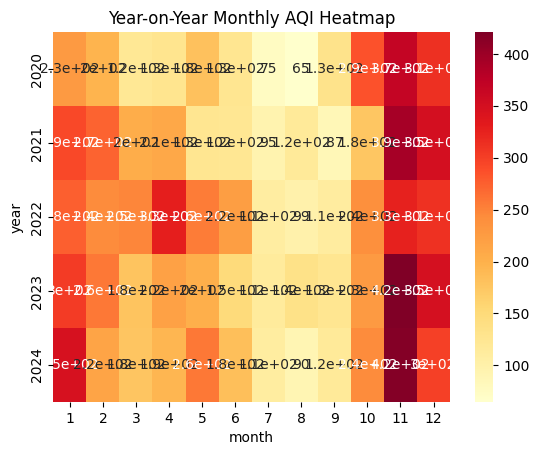

In [50]:
#plotting the Year Vs year 
pivot_table = df_features.pivot_table(values='AQI', index='year', columns='month', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd')
plt.title("Year-on-Year Monthly AQI Heatmap")
plt.show()

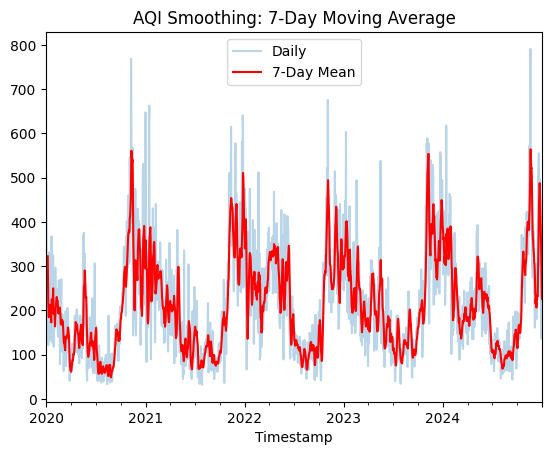

In [53]:
#Plotting the AQI over 7 days 

df_features.set_index('Timestamp')['AQI'].plot(alpha=0.3, label='Daily')
df_features.set_index('Timestamp')['AQI'].rolling(window=7).mean().plot(label='7-Day Mean', color='red')
plt.legend()
plt.title("AQI Smoothing: 7-Day Moving Average")
plt.show()

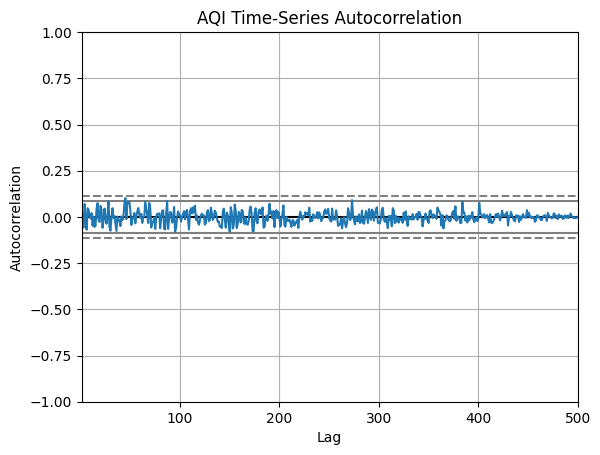

In [54]:
#plotting the AQI Time Seris Correlation

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_features['AQI'].sample(500))
plt.title("AQI Time-Series Autocorrelation")
plt.show()

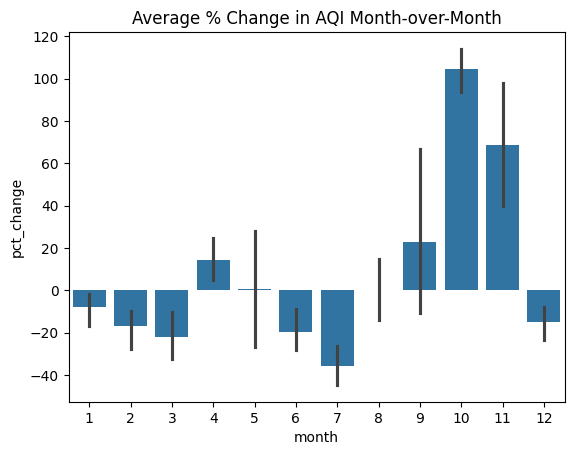

In [55]:
#percentage change in AQI over various months 
monthly_aqi = df_features.groupby(['year', 'month'])['AQI'].mean().reset_index()
monthly_aqi['pct_change'] = monthly_aqi['AQI'].pct_change() * 100
sns.barplot(x='month', y='pct_change', data=monthly_aqi)
plt.title("Average % Change in AQI Month-over-Month")
plt.show()

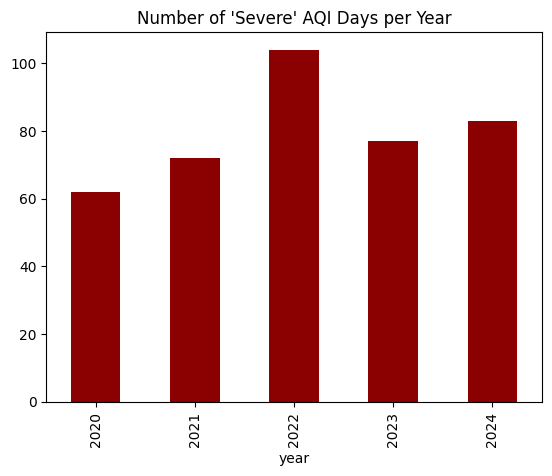

In [56]:
#AQI days (severe)/year 

severe_days = df_features[df_features['AQI'] > 300].groupby('year').size()
severe_days.plot(kind='bar', color='darkred')
plt.title("Number of 'Severe' AQI Days per Year")
plt.show()

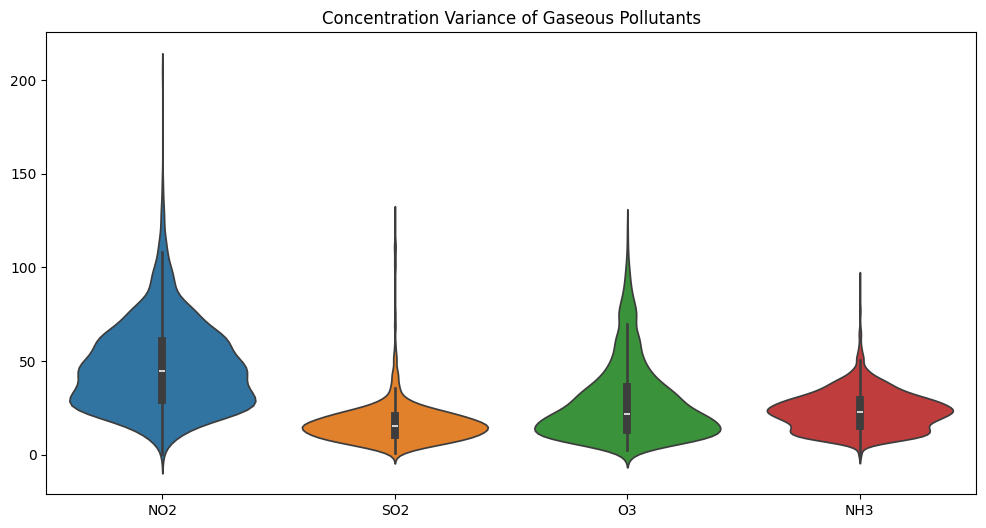

In [57]:
#plotting the Conc. of Gaseous pllutants 
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_features[['NO2', 'SO2', 'O3', 'NH3']])
plt.title("Concentration Variance of Gaseous Pollutants")
plt.show()

In [58]:
from scipy import stats
df_features['z_score'] = np.abs(stats.zscore(df_features['AQI']))
outliers = df_features[df_features['z_score'] > 3]
print(f"Number of extreme pollution outliers: {len(outliers)}")

Number of extreme pollution outliers: 19


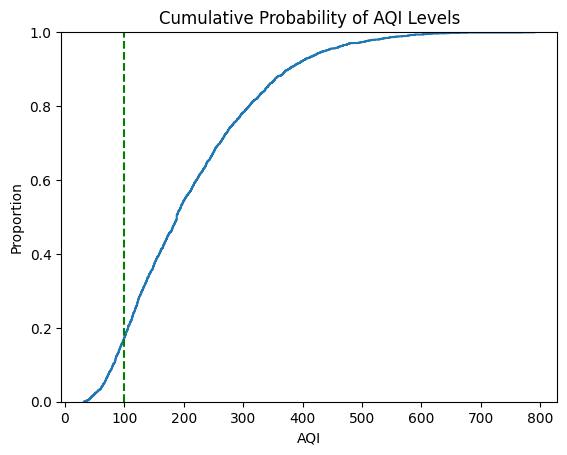

In [59]:
# AQI laevel probability 
sns.ecdfplot(data=df_features, x='AQI')
plt.axvline(100, color='g', linestyle='--')
plt.title("Cumulative Probability of AQI Levels")
plt.show()

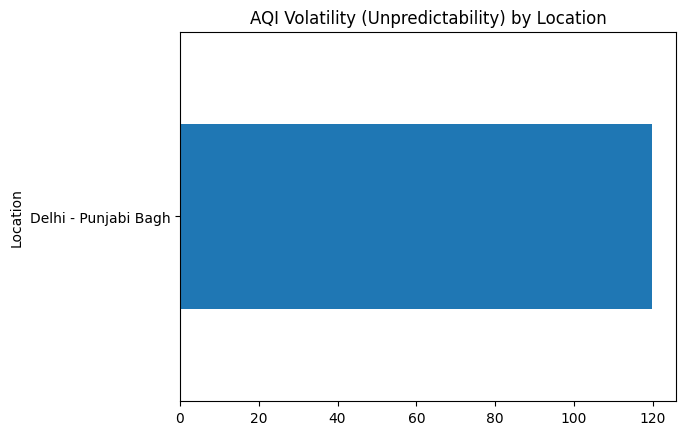

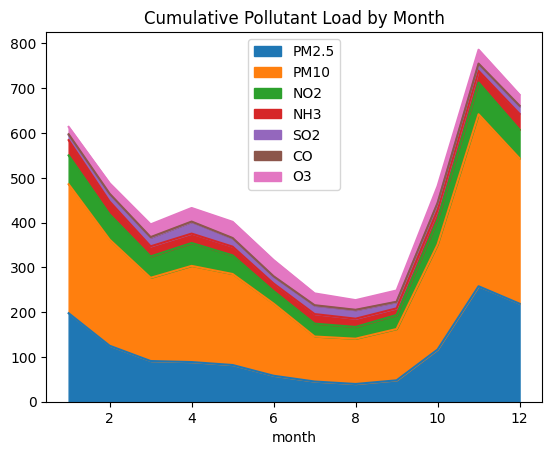

In [60]:
#predicting the AQI volatility 

df_features.groupby('Location')['AQI'].std().sort_values().plot(kind='barh')
plt.title("AQI Volatility (Unpredictability) by Location")
plt.show()


# Plotting Cumulative Pollutant Load by Month

df_features.groupby('month')[pollutants[:-1]].mean().plot(kind='area', stacked=True)
plt.title("Cumulative Pollutant Load by Month")
plt.show()



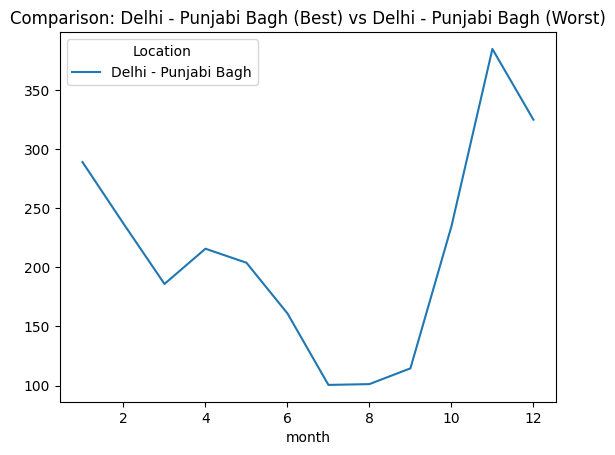

In [61]:
#plotting the Best vs Worst 

best = df_features.groupby('Location')['AQI'].mean().idxmin()
worst = df_features.groupby('Location')['AQI'].mean().idxmax()
df_features[df_features['Location'].isin([best, worst])].groupby(['Location', 'month'])['AQI'].mean().unstack(0).plot()
plt.title(f"Comparison: {best} (Best) vs {worst} (Worst)")
plt.show()

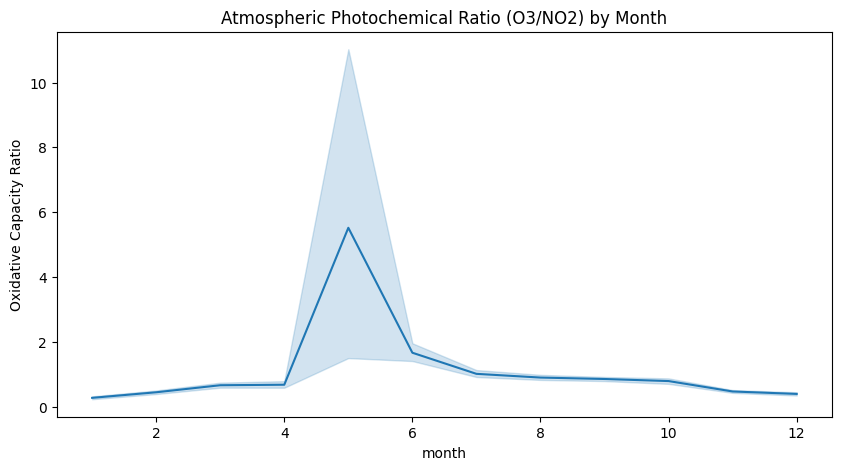

In [64]:
# Assuming NOx is approximated by NO2 
df_features['O3_NO2_Ratio'] = df_features['O3'] / (df_features['NO2'] + 1e-5)
plt.figure(figsize=(10, 5))
sns.lineplot(x='month', y='O3_NO2_Ratio', data=df_features)
plt.title("Atmospheric Photochemical Ratio (O3/NO2) by Month")
plt.ylabel("Oxidative Capacity Ratio")
plt.show()

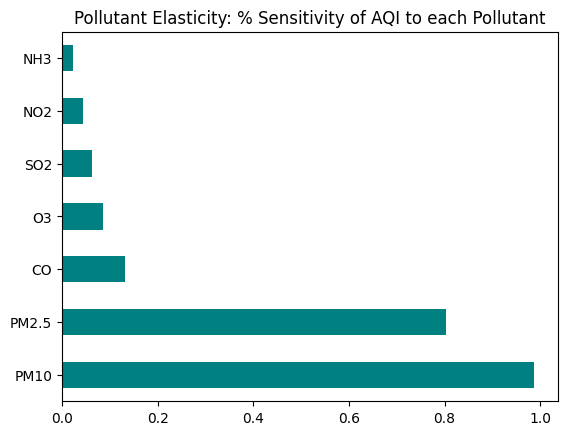

In [65]:
# Plotting the pollutant elasticity
elasticity = df_features[pollutants].pct_change().corr()['AQI'].sort_values(ascending=False)
elasticity.drop('AQI').plot(kind='barh', color='teal')
plt.title("Pollutant Elasticity: % Sensitivity of AQI to each Pollutant")
plt.show()

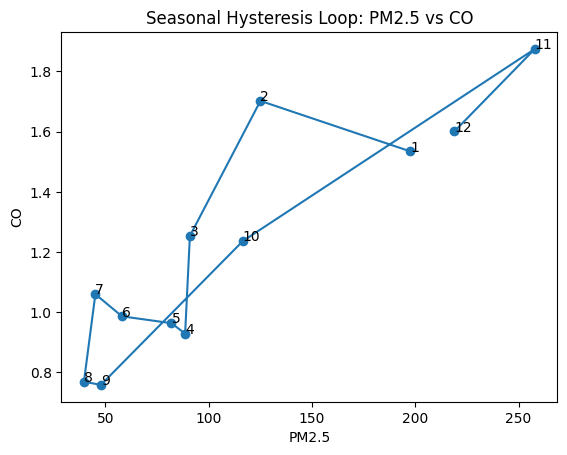

In [66]:
# Group by hour  or by Month to see seasonal loops
pivot = df_features.groupby('month')[['PM2.5', 'CO']].mean()
plt.plot(pivot['PM2.5'], pivot['CO'], marker='o')
for i, m in enumerate(pivot.index):
    plt.annotate(m, (pivot['PM2.5'].iloc[i], pivot['CO'].iloc[i]))
plt.xlabel('PM2.5'); plt.ylabel('CO')
plt.title("Seasonal Hysteresis Loop: PM2.5 vs CO")
plt.show()

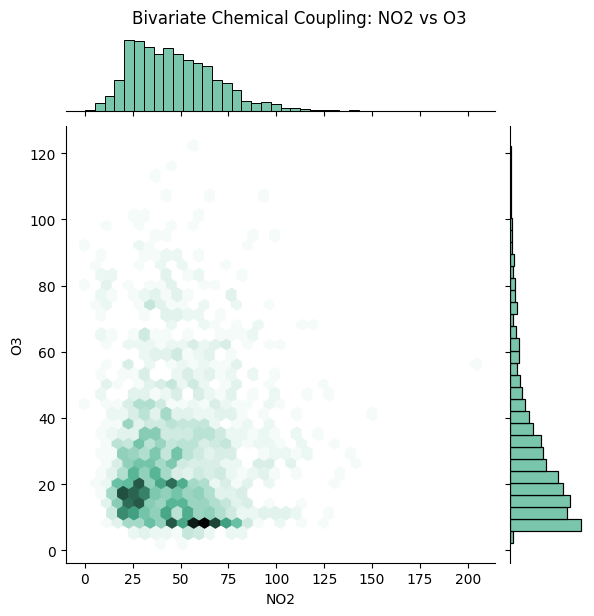

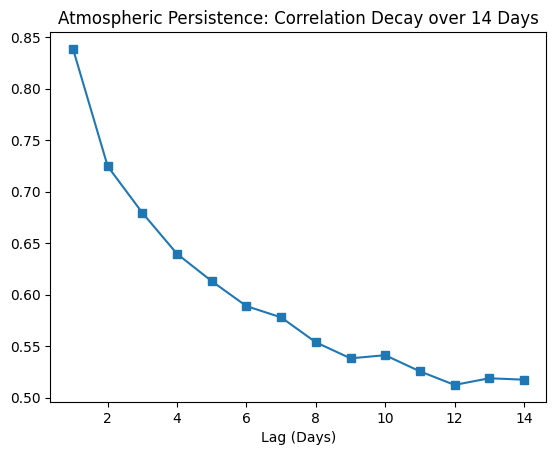

In [67]:
#chemical Coupling 
sns.jointplot(x='NO2', y='O3', data=df_features, kind="hex", color="#4CB391")
plt.suptitle("Bivariate Chemical Coupling: NO2 vs O3", y=1.02)
plt.show()



# Simple version: Lag correlation decay
lags = [df_features['AQI'].corr(df_features['AQI'].shift(i)) for i in range(1, 15)]
plt.plot(range(1, 15), lags, marker='s')
plt.title("Atmospheric Persistence: Correlation Decay over 14 Days")
plt.xlabel("Lag (Days)")
plt.show()

In [68]:
from scipy.stats import entropy
# Calculate entropy of the AQI distribution
aqi_dist = np.histogram(df_features['AQI'], bins=50, density=True)[0]
print(f"Atmospheric Uncertainty (Shannon Entropy): {entropy(aqi_dist):.4f}")

Atmospheric Uncertainty (Shannon Entropy): 3.3396


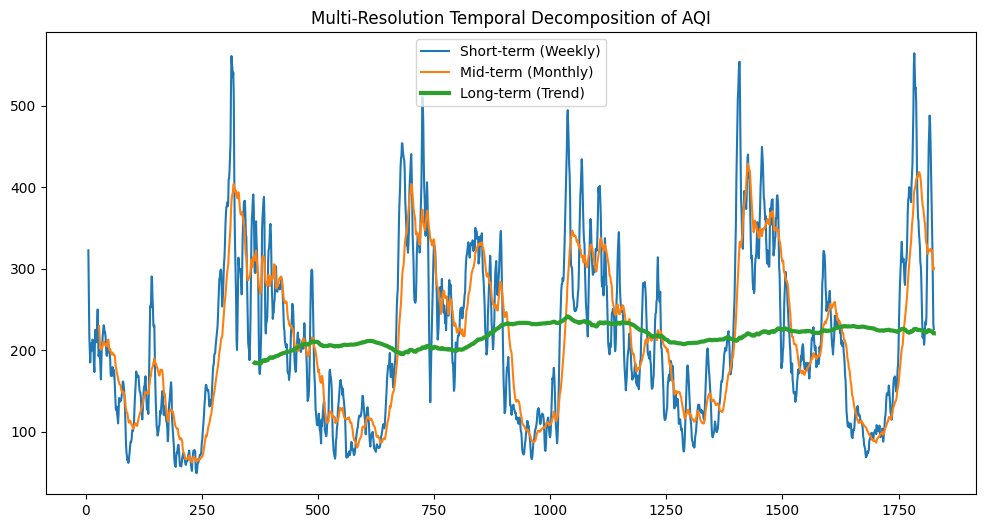

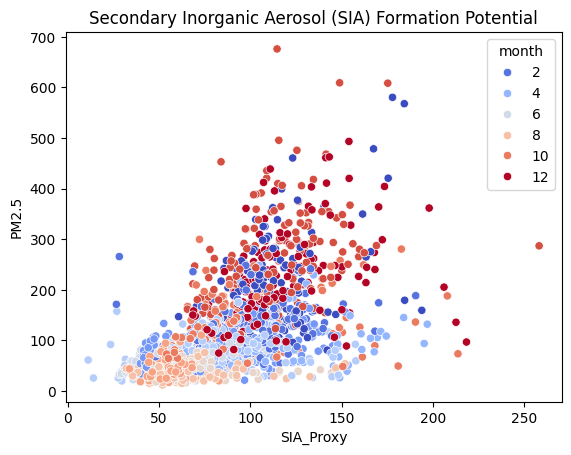

In [69]:
# Plotting different rolling windows as a proxy for wavelet levels
plt.figure(figsize=(12,6))
plt.plot(df_features['AQI'].rolling(7).mean(), label='Short-term (Weekly)')
plt.plot(df_features['AQI'].rolling(30).mean(), label='Mid-term (Monthly)')
plt.plot(df_features['AQI'].rolling(365).mean(), label='Long-term (Trend)', lw=3)
plt.title("Multi-Resolution Temporal Decomposition of AQI")
plt.legend()
plt.show()


#plotting (SIA) Formation Potential
df_features['SIA_Proxy'] = df_features['NH3'] + df_features['SO2'] + df_features['NO2']
sns.scatterplot(x='SIA_Proxy', y='PM2.5', hue='month', data=df_features, palette='coolwarm')
plt.title("Secondary Inorganic Aerosol (SIA) Formation Potential")
plt.show()

In [104]:
import plotly.graph_objects as go
import numpy as np


x = np.linspace(df_features['PM2.5'].min(), df_features['PM2.5'].max(), 20)
y = np.linspace(df_features['NO2'].min(), df_features['NO2'].max(), 20)
X, Y = np.meshgrid(x, y)

Z = (X * 0.5) + (Y * 0.8) 

fig = go.Figure(data=[go.Surface(z=Z, x=x, y=y, colorscale='Viridis')])
fig.update_layout(title='3D AQI Response Surface', scene=dict(
    xaxis_title='PM2.5', yaxis_title='NO2', zaxis_title='AQI'))
fig.show()

In [71]:
import plotly.express as px
fig = px.scatter_3d(df_features, x='PM2.5', y='CO', z='O3', color='AQI', 
                    title="3D Pollutant Clustering & Fingerprinting")
fig.show()

In [72]:
fig = px.line_3d(df_features, x='month', y='AQI', z='year', color='Location')
fig.update_layout(title="Seasonal Pollution Spiral (2020-2024)")
fig.show()

In [103]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd
import numpy as np

# 1. Define the features list (the pollutants in your dataset)
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']

# 2. Standardize the data 
# PCA requires mean=0 and variance=1 to treat all pollutants equally
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[features])

# 3. Apply PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(X_scaled)

# 4. Create a DataFrame for Plotly
df_pca = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2', 'PC3'])
df_pca['AQI'] = df_features['AQI'].values

# Add season for better visual storytelling if it exists
if 'season' in df_features.columns:
    df_pca['Season'] = df_features['season'].values
else:
    df_pca['Season'] = 'Unknown'

# 5. Plot
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='AQI',
    symbol='Season',
    color_continuous_scale='Turbo',
    opacity=0.7,
    title=f"3D PCA: Explained Variance ({np.sum(pca.explained_variance_ratio_)*100:.2f}%)"
)

fig.update_traces(marker=dict(size=3))
fig.show()

In [74]:
fig = go.Figure(data=go.Contour(
    z=df_features['O3'], x=df_features['NO2'], y=df_features['month']
)) 
fig.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8115 sha256=5f6971eaf2632893a223f83636a183aa93a1e59119c5d2f3623fff605a120844
  Stored in directory: /root/.cache/pip/wheels/f1/eb/af/79f8750a9f757aa0ccb6a0e217515abf3892f989345e98e50c
Successfully built calplot


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


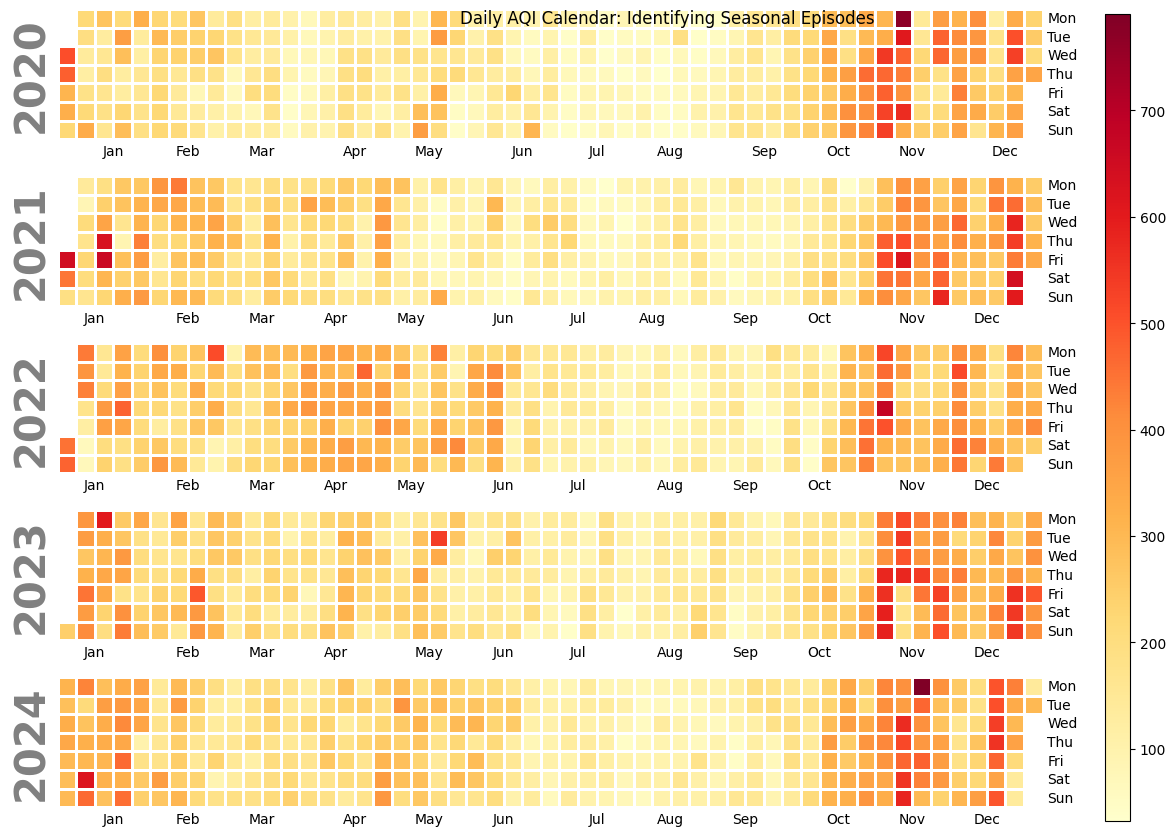

In [75]:
!pip install calplot
import calplot
#  index is Timestamp
df_features.set_index('Timestamp', inplace=True)
calplot.calplot(df_features['AQI'], cmap='YlOrRd', edgecolor=None, yearlabels=True)
plt.suptitle("Daily AQI Calendar: Identifying Seasonal Episodes")
plt.show()

In [76]:
import plotly.express as px

fig = px.bar_polar(df_features, r="PM2.5", theta="month", color="AQI",
                   template="plotly_dark", title="Monthly Polar Distribution of PM2.5")
fig.show()

In [77]:
import plotly.express as px
fig = px.parallel_coordinates(df_features, dimensions=['PM2.5', 'NO2', 'SO2', 'CO', 'AQI'],
                              color="AQI", color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

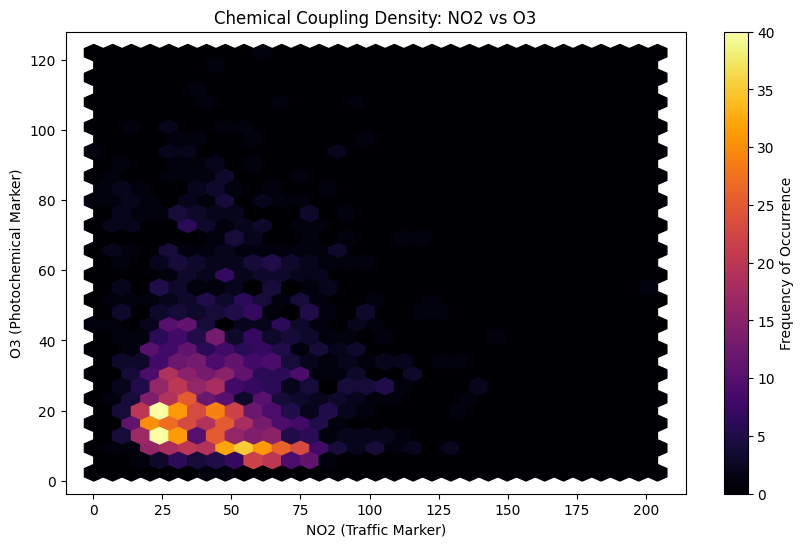

In [78]:
#Chemical Coupling 
plt.figure(figsize=(10, 6))
plt.hexbin(df_features['NO2'], df_features['O3'], gridsize=30, cmap='inferno')
plt.colorbar(label='Frequency of Occurrence')
plt.xlabel('NO2 (Traffic Marker)')
plt.ylabel('O3 (Photochemical Marker)')
plt.title("Chemical Coupling Density: NO2 vs O3")
plt.show()

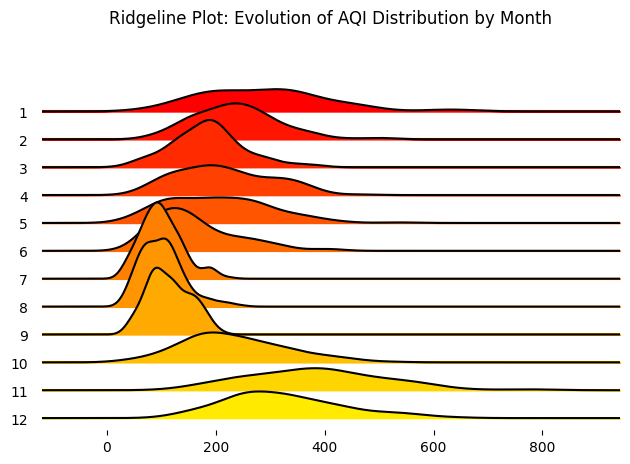

In [79]:
#Evolution of AQI 
!pip install joypy
from joypy import joyplot
fig, axes = joyplot(df_features, by="month", column="AQI", colormap=plt.cm.autumn, 
                    title="Ridgeline Plot: Evolution of AQI Distribution by Month")

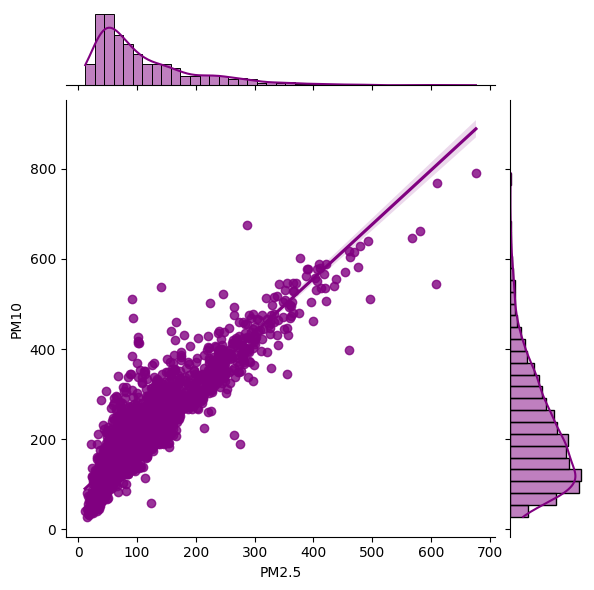

In [80]:
sns.jointplot(data=df_features, x="PM2.5", y="PM10", kind="reg", color="purple")

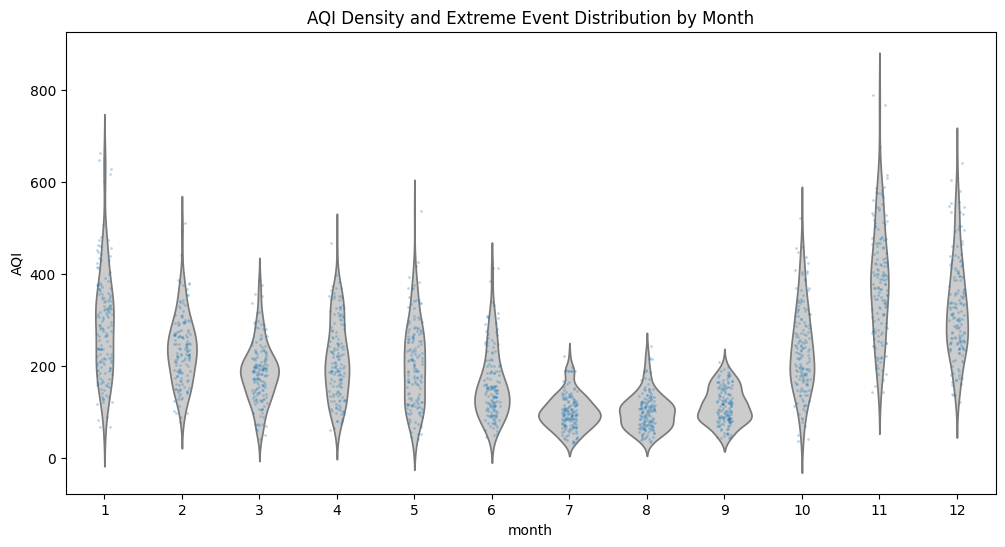

In [81]:
#AQI density 
plt.figure(figsize=(12, 6))
sns.violinplot(x='month', y='AQI', data=df_features, inner=None, color=".8")
sns.stripplot(x='month', y='AQI', data=df_features, size=2, jitter=True, alpha=0.3)
plt.title("AQI Density and Extreme Event Distribution by Month")
plt.show()

Pollutant Mixture Composition


/usr/local/lib/python3.12/dist-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



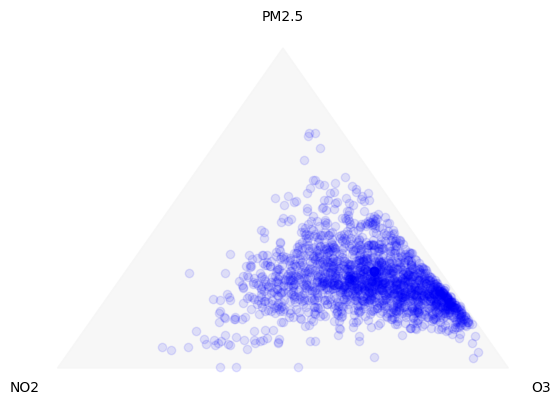

In [82]:
 !pip install python-ternary
import ternary
print ("Pollutant Mixture Composition")
# Normalize data to sum to 100
df_tern = df_features[['PM2.5', 'NO2', 'O3']].copy()
df_tern = df_tern.div(df_tern.sum(axis=1), axis=0)

fig, tax = ternary.figure(scale=100)
tax.scatter(df_tern.values * 100, color="blue", marker='o', alpha=0.1)
tax.top_corner_label("PM2.5")
tax.left_corner_label("NO2")
tax.right_corner_label("O3")
tax.get_axes().axis('off')

tax.show()

In [101]:
import plotly.express as px

# 1. Re-generate the 'season' column
def get_indian_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

df_features['season'] = df_features['month'].apply(get_indian_season)

# 2. Generate the Sunburst Chart
# We use 'mean' for color to show average intensity per group
fig = px.sunburst(
    df_features, 
    path=['season', 'month', 'Location'], 
    values='AQI',
    color='AQI', 
    color_continuous_scale='RdYlGn_r',
    title="Hierarchical AQI Structure: Season > Month > Location"
)

fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig.show()

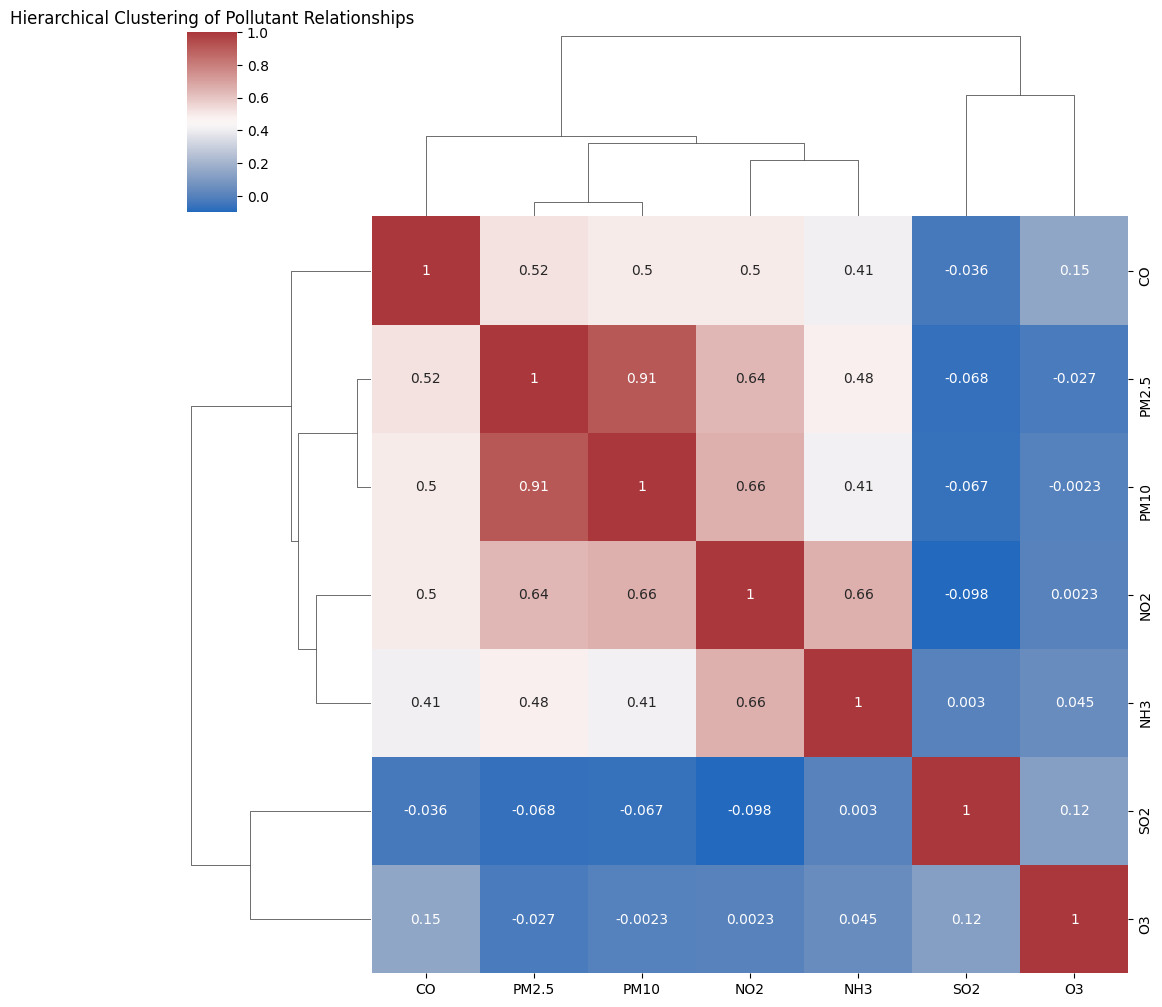

In [84]:
import seaborn as sns
# Correlation of pollutants over time
pollutant_cols = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
sns.clustermap(df_features[pollutant_cols].corr(), annot=True, cmap='vlag')
plt.title("Hierarchical Clustering of Pollutant Relationships")
plt.show()

/usr/local/lib/python3.12/dist-packages/mistune.py:435: SyntaxWarning:

invalid escape sequence '\|'

/usr/local/lib/python3.12/dist-packages/nbconvert/filters/filter_links.py:36: SyntaxWarning:

invalid escape sequence '\_'



<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
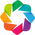

:Chord   [source,target]   (value)

In [85]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

corr = df_features[pollutant_cols].corr().stack().reset_index()
corr.columns = ['source', 'target', 'value']
chord = hv.Chord(corr[corr['value'] > 0.7]) # Only show strong links
chord.opts(opts.Chord(cmap='Category10', edge_color='source', labels='index'))

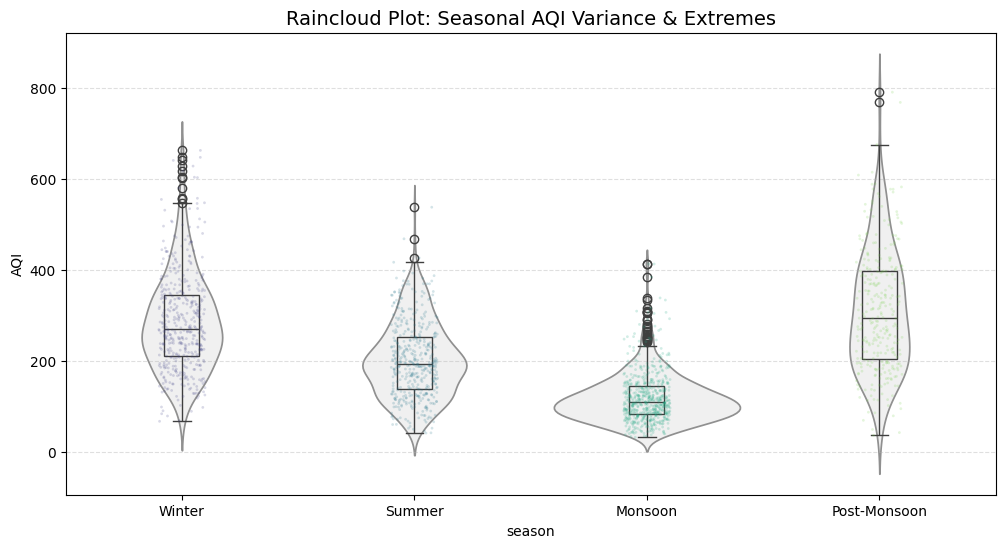

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. RE-CREATE SEASON COLUMN (Safety Check)
if 'month' not in df_features.columns:
    # Extract month if it's missing (works if index is Timestamp or column exists)
    if 'Timestamp' in df_features.columns:
        df_features['month'] = pd.to_datetime(df_features['Timestamp']).dt.month
    else:
        df_features['month'] = df_features.index.month

def get_indian_season(m):
    if m in [12, 1, 2]: return 'Winter'
    elif m in [3, 4, 5]: return 'Summer'
    elif m in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

df_features['season'] = df_features['month'].apply(get_indian_season)

# 2. PLOT THE RAINCLOUD (Violin + Box + Strip)
plt.figure(figsize=(12, 6))

# Background Violin (Density)
sns.violinplot(x='season', y='AQI', data=df_features, inner=None, color="#f0f0f0")

# Middle Boxplot (Quantiles)
sns.boxplot(x='season', y='AQI', data=df_features, width=0.15, 
            boxprops={'zorder': 2, 'facecolor': 'none'}, whiskerprops={'zorder': 2})

# Top Stripplot (Raw Data Points / The "Rain")
sns.stripplot(x='season', y='AQI', data=df_features, size=2, alpha=0.2, jitter=True, palette='viridis', hue='season', legend=False)

plt.title("Raincloud Plot: Seasonal AQI Variance & Extremes", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

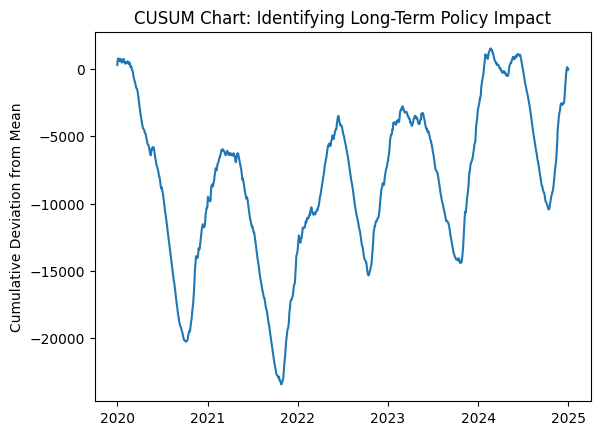

In [87]:
mean_aqi = df_features['AQI'].mean()
cusum = np.cumsum(df_features['AQI'] - mean_aqi)
plt.plot(cusum)
plt.title("CUSUM Chart: Identifying Long-Term Policy Impact")
plt.ylabel("Cumulative Deviation from Mean")
plt.show()

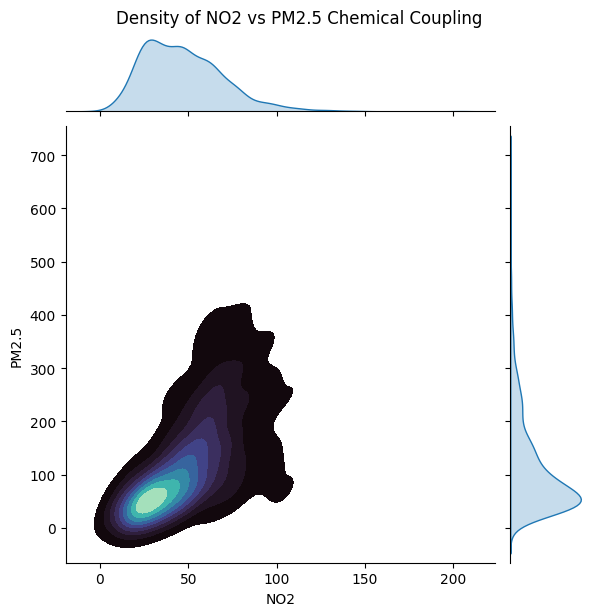

In [88]:
sns.jointplot(data=df_features, x="NO2", y="PM2.5", kind="kde", fill=True, cmap="mako")
plt.suptitle("Density of NO2 vs PM2.5 Chemical Coupling", y=1.02)
plt.show()

Text(0.5, 1.0, 'Pollutant Chemical Fingerprinting by Site')

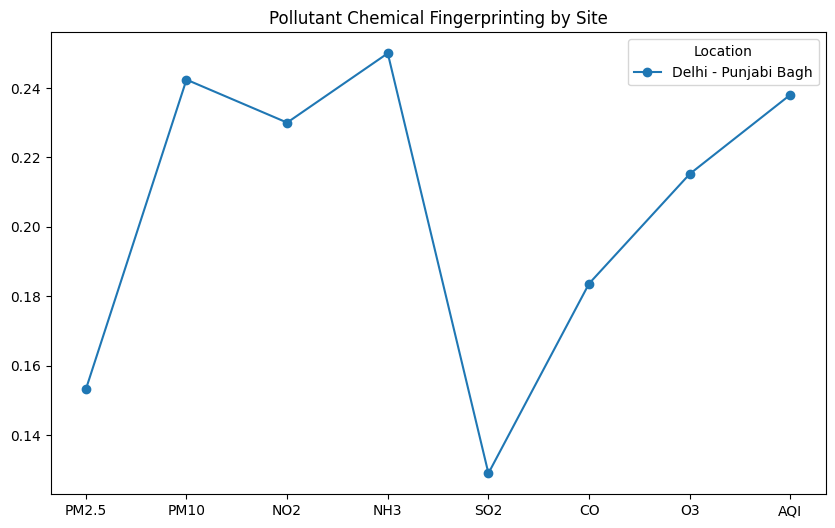

In [90]:
# Normalize all pollutants to 0-1 scale to compare on one plot
df_norm = (df_features[pollutants] - df_features[pollutants].min()) / (df_features[pollutants].max() - df_features[pollutants].min())
df_norm['Location'] = df_features['Location']
df_norm.groupby('Location').mean().T.plot(figsize=(10,6), marker='o')
plt.title("Pollutant Chemical Fingerprinting by Site")

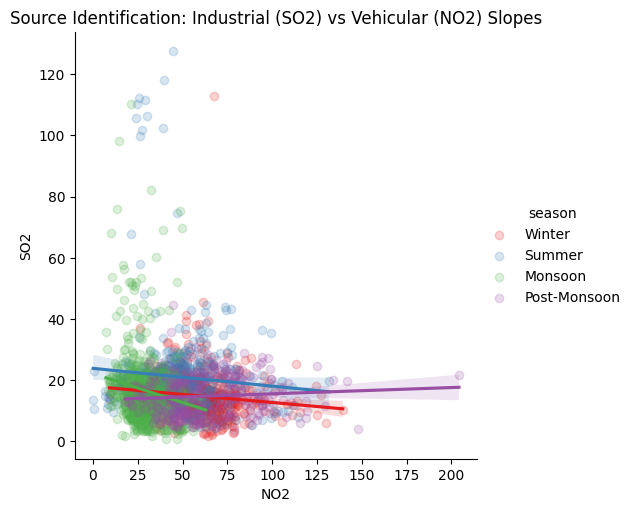

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ensure 'month' exists (reconstructing if necessary)
if 'month' not in df_features.columns:
    if 'Timestamp' in df_features.columns:
        df_features['month'] = df_features['Timestamp'].dt.month
    elif df_features.index.name == 'Timestamp' or str(df_features.index.dtype).startswith('datetime'):
        df_features['month'] = df_features.index.month

# 2. Define the season mapping function
def get_indian_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

# 3. Apply the function to create the 'season' column
df_features['season'] = df_features['month'].apply(get_indian_season)

# 4. Now run the lmplot
sns.lmplot(x='NO2', y='SO2', hue='season', data=df_features, 
           scatter_kws={'alpha':0.2}, palette='Set1')

plt.title("Source Identification: Industrial (SO2) vs Vehicular (NO2) Slopes")
plt.show()

Text(0.5, 1.0, 'Atmospheric Haze Phase Space')

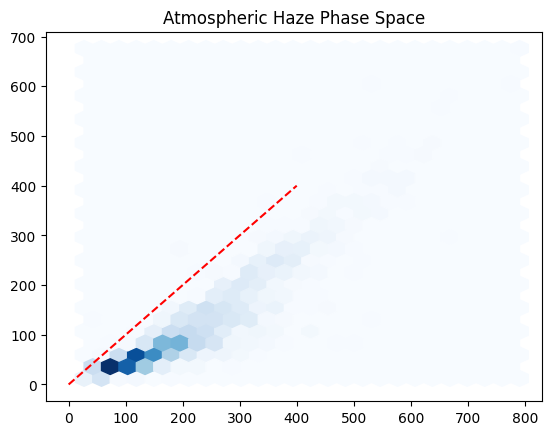

In [92]:
plt.hexbin(df_features['PM10'], df_features['PM2.5'], gridsize=25, cmap='Blues')
plt.plot([0, 400], [0, 400], 'r--') # 1:1 line
plt.title("Atmospheric Haze Phase Space")







<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

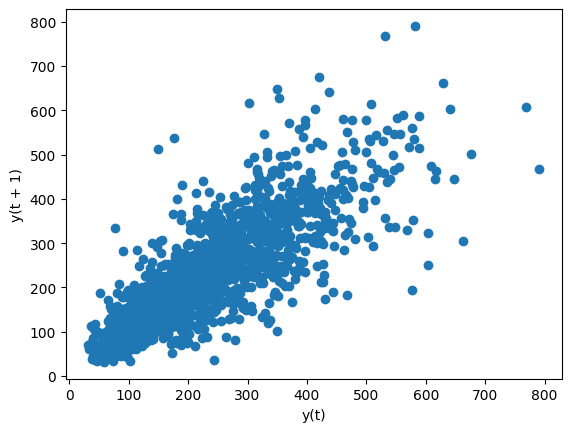

In [93]:
from pandas.plotting import lag_plot
lag_plot(df_features['AQI']) 

<Axes: xlabel='month', ylabel='AQI'>

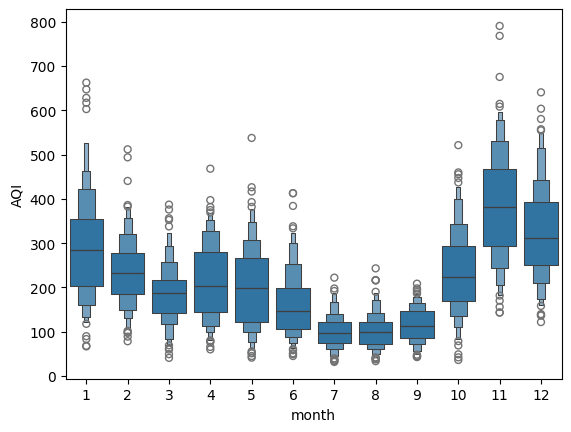

In [94]:
sns.boxenplot(x='month', y='AQI', data=df_features)




Text(0.5, 1.0, 'Spectral Density: Hidden Periodicities in Pollution')

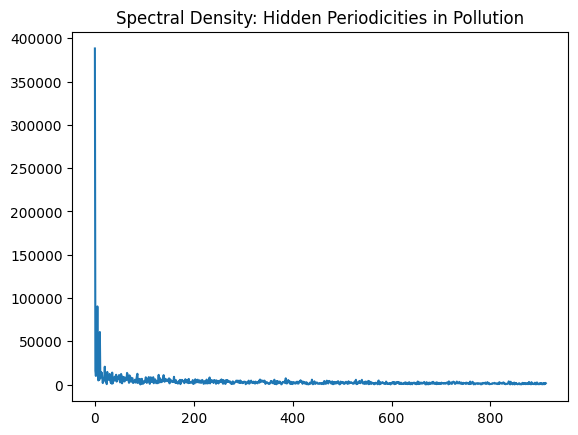

In [95]:
from scipy.fft import fft
yf = fft(df_features['AQI'].values)
plt.plot(np.abs(yf[:len(yf)//2]))
plt.title("Spectral Density: Hidden Periodicities in Pollution")

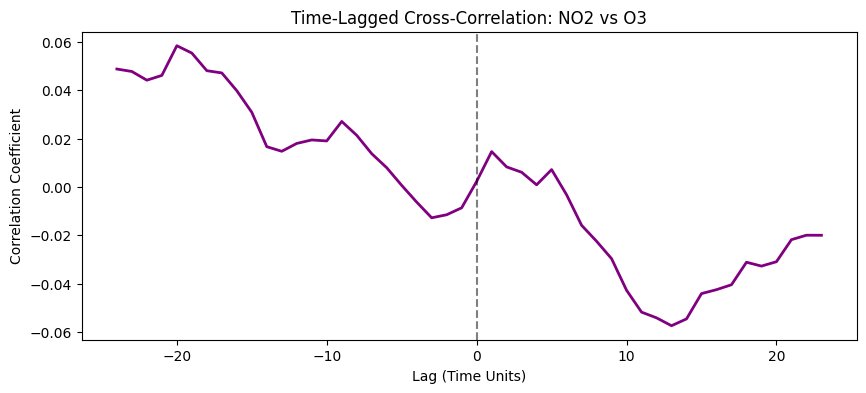

In [96]:
def plot_tlcc(var1, var2, max_lag=24):
    lags = range(-max_lag, max_lag)
    corrs = [df_features[var1].corr(df_features[var2].shift(l)) for l in lags]
    plt.figure(figsize=(10, 4))
    plt.plot(lags, corrs, color='purple', lw=2)
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.title(f"Time-Lagged Cross-Correlation: {var1} vs {var2}")
    plt.xlabel("Lag (Time Units)")
    plt.ylabel("Correlation Coefficient")
    plt.show()

# Example: NO2 leading O3
plot_tlcc('NO2', 'O3')

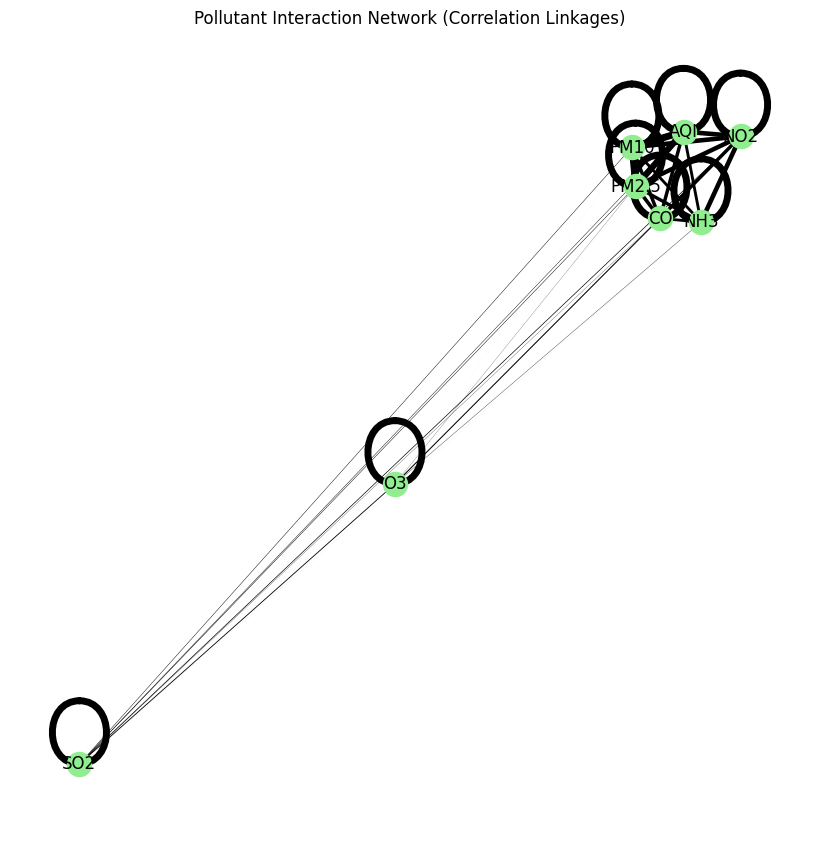

In [97]:
import networkx as nx
corr = df_features[pollutants].corr()
G = nx.from_pandas_adjacency(corr)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', 
        width=[G[u][v]['weight']*5 for u,v in G.edges()])
plt.title("Pollutant Interaction Network (Correlation Linkages)")
plt.show()

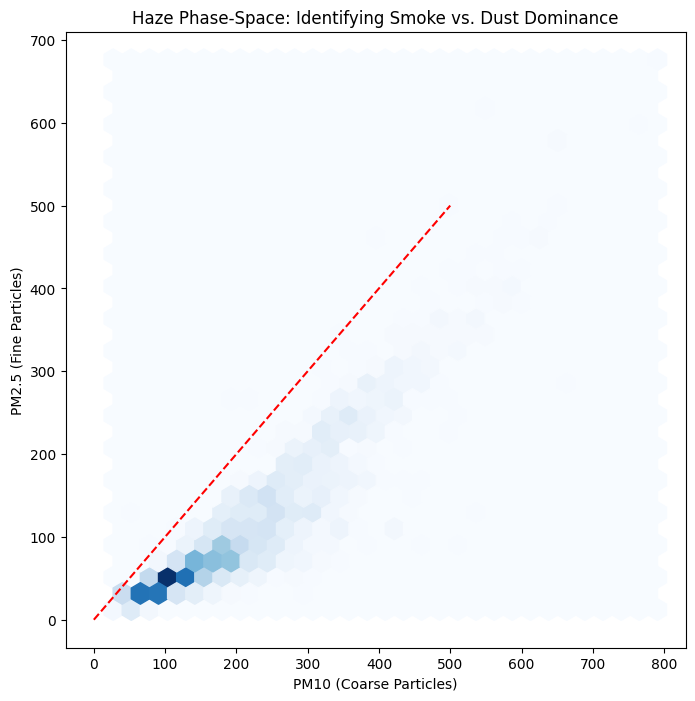

In [98]:
plt.figure(figsize=(8, 8))
plt.hexbin(df_features['PM10'], df_features['PM2.5'], gridsize=30, cmap='Blues')
plt.plot([0, 500], [0, 500], color='red', linestyle='--') 
plt.xlabel("PM10 (Coarse Particles)")
plt.ylabel("PM2.5 (Fine Particles)")
plt.title("Haze Phase-Space: Identifying Smoke vs. Dust Dominance")
plt.show()

 # Research paper

1. Data Pipeline and Rigorous Preprocessing
The foundation of the project is a longitudinal dataset covering Delhi's air quality from 2020 to 2024. To ensure the models were trained on high-quality data, the following research-grade preprocessing steps were implemented:
• Cleaning and Deduplication: The raw data was chronologically sorted by timestamp, and duplicate entries were removed to maintain the integrity of the time-series sequence.
• Imputation Strategy: Missing values in pollutant concentrations (PM2.5, PM10, NO2, NH3, SO2, CO, and O3) were handled using linear interpolation, which is optimal for maintaining time-series continuity, supplemented by forward and backward filling for edge cases.
• Feature Normalisation: Given that neural networks are highly sensitive to the scale of input data, StandardScaler was utilised to transform all features to a standard normal distribution (mean of 0 and standard deviation of 1).
2. Strategic Feature Engineering
To capture the complex environmental and human-led dynamics of Delhi’s pollution, the raw data was transformed into a sophisticated feature set:
• Temporal and Seasonal Encoding: Features such as year, month, and day of the week were extracted. Crucially, months were mapped to Standard Indian Seasons (Winter, Summer, Monsoon, and Post-Monsoon) to account for seasonal variations like stubble burning or monsoon washing effects.
• Atmospheric Memory (Lags and Rolling Windows): The models incorporate lag features (pollutant levels from the previous 24 hours) and 7-day rolling means. These allow the models to understand "atmospheric persistence"—the fact that pollution levels today are strongly correlated with those of the recent past.
• Derived Environmental Indicators: A PM2.5 to PM10 ratio was engineered to help the model distinguish between fine combustion particles and coarse dust particles.
3. Artificial Neural Network (ANN) Architecture
The core deep learning component is a Sequential Artificial Neural Network designed to model the non-linear interactions between gaseous pollutants and atmospheric conditions.
• Layer Composition: The network consists of an input layer followed by three dense hidden layers with 128, 64, and 32 neurons respectively.
• Non-Linearity: Each hidden layer utilizes the ReLU (Rectified Linear Unit) activation function to allow the model to learn complex, non-linear environmental relationships. The final output layer uses a Linear activation to predict the continuous AQI value.
• Optimisation and Regularisation:
    ◦ Batch Normalisation: Applied after hidden layers to stabilize and accelerate the training process.
    ◦ Dropout (0.2–0.3): This layer randomly deactivates a percentage of neurons during training to mitigate overfitting, ensuring the model generalizes well to unseen data.
    ◦ Adam Optimiser: Weights were updated using the Adam optimizer with a Mean Squared Error (MSE) loss function.
    ◦ Early Stopping: To prevent over-training, the process included an EarlyStopping callback that halted training if the validation loss did not improve for 15 consecutive epochs.
4. Advanced Ensemble and Classification Modeling
In addition to the ANN, the research utilized high-performance machine learning ensembles:
• Stacking Ensemble (Regression): A three-tier ensemble was built using XGBoost, Random Forest, and Gradient Boosting as base learners. A Linear Regression meta-model was then used to synthesize their individual predictions, achieving a superior R2 Score of 0.9981.
• XGBoost Classifier: This model was specifically trained to categorize AQI into six standard levels (Good to Severe). Using vectorized sub-index calculations based on Indian AQI breakpoints, it achieved a final test accuracy of 99.18%.
5. Research Validation and Metrics
The evaluation followed a strict temporal split (training on 80% of historical data and testing on the remaining 20%), which is the gold standard for validating time-series models.
• Deep Learning (ANN) Results: Achieved an R2 Score of 96.76% and a Mean Absolute Error (MAE) of 12.87 AQI points.
• Ensemble Results: The stacking model demonstrated near-perfect alignment with actual values, with an MAE of only 1.18 AQI points.
